# Least-squares fitting to estimate 3D rotation vector from 2D images 

This script estimates the rotational axis, for solid body rotation about an aribtrary axis in 3D, that gives rise to an observed displacement field computed from 2D images.  

Input list of point locations and displacement fields:
{(r_x, r_z)}_i for i in N

Params: (w_x, w_y, w_z)



In [204]:
import numpy as np
import cv2
import pandas as pd
import os
# Load the data

folder = 'C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images_2020-12-10 23-38'
track_folder = 'RotationAnalysisTracks'
file = 'RotationTrack.csv'

R = 448/2.0 # Aggregate size for test images
df = pd.read_csv(os.path.join(folder, track_folder, file))

nTracks = int(max(df['feature ID']+1))

print(nTracks)

nTimepoints = int(len(df['Time'])/nTracks)
print(nTimepoints)

# generate a dict containing time series for each track
df_tracks = {ii : df.loc[df['feature ID']==ii] for ii in range(nTracks)}

df_tracks




7
12


{0:     Unnamed: 0  feature ID  Time  feature centroid X  feature centroid Z  \
 0            0         0.0   0.0          238.510437          368.503632   
 1            1         0.0   1.0          239.435501          369.530762   
 2            2         0.0   2.0          239.448975          371.500305   
 3            3         0.0   3.0          240.405365          372.553680   
 4            4         0.0   4.0          241.458206          374.468262   
 5            5         0.0   5.0          243.508331          375.400330   
 6            6         0.0   6.0          244.571091          377.313751   
 7            7         0.0   7.0          245.547760          378.365845   
 8            8         0.0   8.0          246.617279          380.284760   
 9            9         0.0   9.0          247.570755          381.331787   
 10          10         0.0  10.0          248.618439          383.253418   
 11          11         0.0  11.0          249.579788          384.308014

In [206]:
# Load the actual rotation parameters for the test images
df_rotation = pd.read_csv(os.path.join(folder, 'RotationParameters.csv'))

omega_true = df_rotation['Omega'][0]
p_x_true, p_y_true, p_z_true = df_rotation['p_x'][0], df_rotation['p_y'][0], df_rotation['p_z'][0]

omega_vect_true = omega_true*np.array([p_x_true, p_y_true, p_z_true])
print(omega_true)
print(p_x_true, p_y_true, p_z_true)

0.02
0.0 1.0 0.0


[  1.06871593 -82.10527704]
[ 1.46305612 48.35440337]


<IPython.core.display.Javascript object>


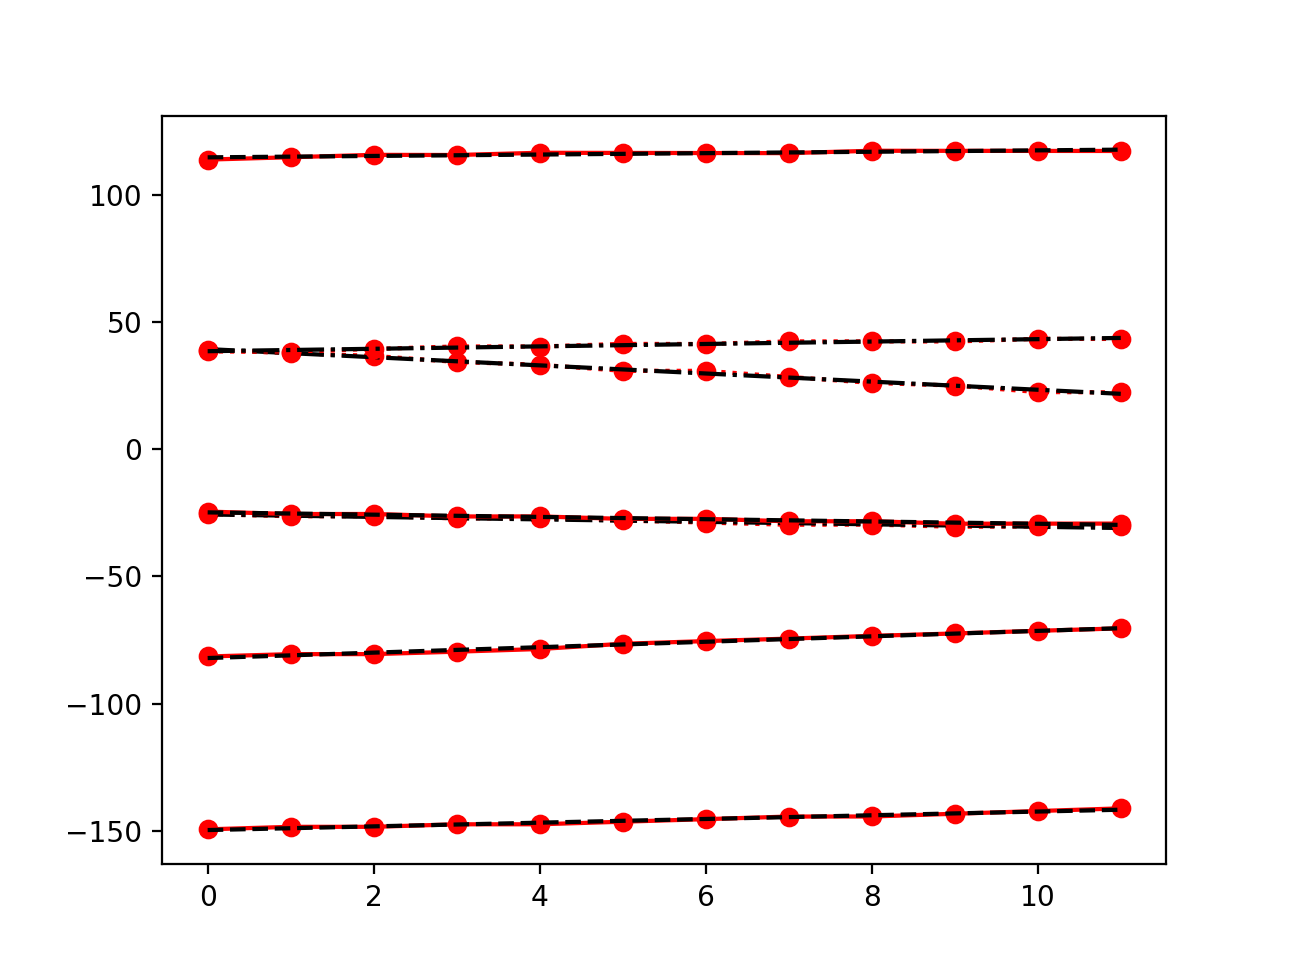

<IPython.core.display.Javascript object>


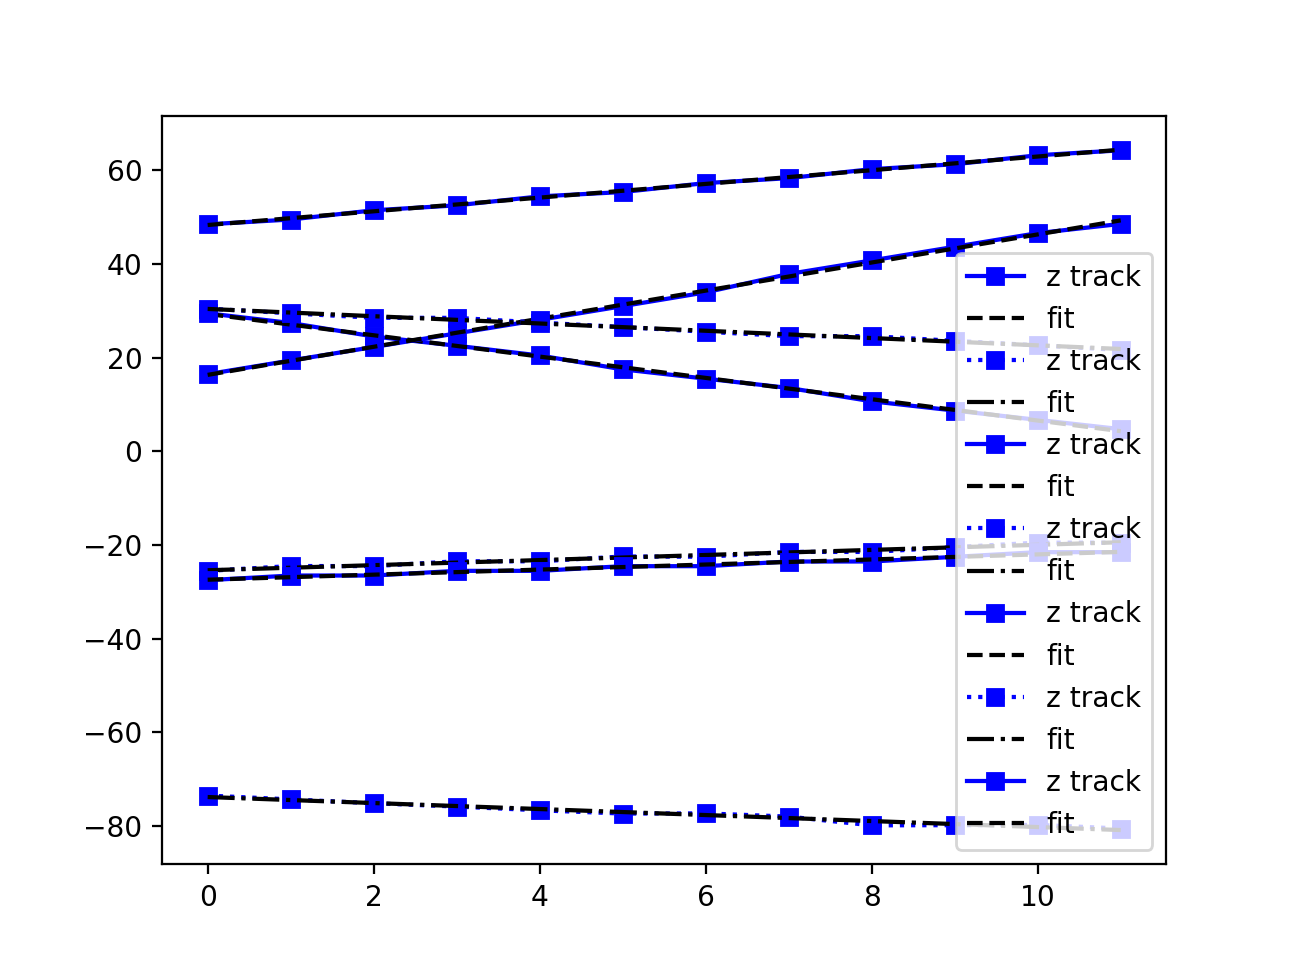

[-1.59960244 39.44404602]
[ -0.64115175 -73.81007464]
[  0.27485198 114.8786492 ]
[-2.2769149  29.36420069]
[ -0.4844769  -25.61181797]
[  0.54377469 -25.37784322]
[   0.72776197 -149.7695111 ]
[ 2.99981124 16.34819344]
[ 0.47454898 38.61295221]
[-0.77766216 30.43479567]
[ -0.44728963 -24.79608428]
[  0.54094285 -27.39772699]


In [207]:
# Calculate centroid velocity for each track
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib notebook


time_vect = np.array(range(nTimepoints))

image_centroids_x = {}
image_centroids_z = {}
centroids_x = {}
centroids_z = {}
centroids_velocity_x = {}
centroids_velocity_z = {}

for ii in range(nTracks):
    image_centroids_x[ii], image_centroids_z[ii] = np.array(df_tracks[ii]['feature centroid X']), np.array(df_tracks[ii]['feature centroid Z'])
    sphere_centroids_x, sphere_centroids_z = np.array(df_tracks[ii]['sphere centroid X']), np.array(df_tracks[ii]['sphere centroid Z'])
    
    centroids_x[ii] = image_centroids_x[ii] - sphere_centroids_x
    centroids_z[ii] = image_centroids_z[ii] - sphere_centroids_x
    
    poly_x = np.polyfit(time_vect, centroids_x[ii], deg = 1)
    poly_z = np.polyfit(time_vect, centroids_z[ii], deg = 1)
    
    print(poly_x)
    print(poly_z)
    
    centroids_velocity_x[ii] = poly_x[0]
    centroids_velocity_z[ii] = poly_z[0]
    
    plt.figure(1)
    plt.plot(time_vect, centroids_x[ii], color = 'r', marker ='o',label ='x track')
    plt.plot(time_vect, poly_x[0]*time_vect + poly_x[1], color = 'k', label ='fit')

    
    
    plt.figure(2)
    plt.plot(time_vect, centroids_z[ii], color = 'b', marker ='s', label ='z track')
    plt.plot(time_vect, poly_z[0]*time_vect + poly_z[1], color = 'k',label ='fit')

plt.legend()
plt.show()

## Plot trajectories of the tracked features


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


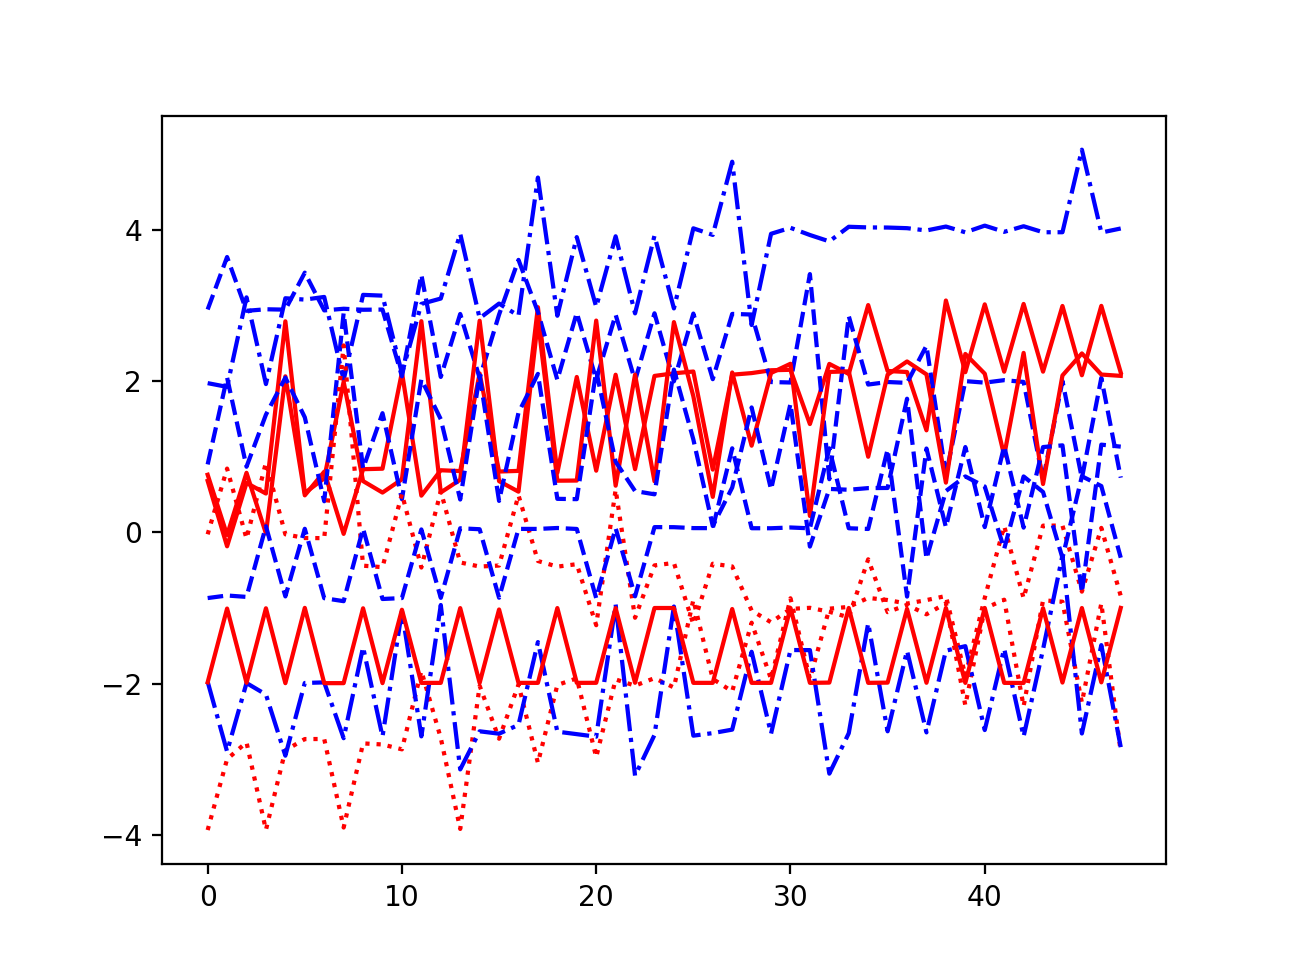

KeyError: 5

In [209]:


plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) +
                           cycler('linestyle', ['-', '--', ':', '-.'])))
plt.figure()

for ii in range(nTracks):
    
    plt.scatter(image_centroids_x[ii], image_centroids_z[ii], color = 'b', label = ii)
    plt.scatter(image_centroids_x[ii][-1], image_centroids_z[ii][-1], 100, marker = 'X', color = 'r')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.title('Tracks of surface features')
plt.show()


# Centroid displacements
plt.figure()

for ii in range(nTracks):
    
    plt.plot(centroids_disp_x[ii], label = 'track'+str(ii)+' v_x', color = 'r')
    plt.plot(centroids_disp_z[ii], label = 'track'+str(ii)+' v_z', color = 'b')

plt.xlabel('Time')
plt.ylabel('Velocity (px/frame)')
plt.title('Velocity of tracked features')
plt.legend()
plt.show()



In [210]:
# Find the initial position of the tracked features

time_point = int(nTimepoints/2)

# Initial position of the tracked points
init_pos_x = {key: centroids_x[key][time_point] for key in centroids_x.keys()}
init_pos_z = {key: centroids_z[key][time_point] for key in centroids_z.keys()}
init_pos_y = {key: (R**2 - centroids_x[key][time_point]**2 - centroids_z[key][time_point]**2)**(1/2) for key in centroids_x.keys()}

print(init_pos_x)
print(init_pos_y)
print(init_pos_z)

{0: -75.42890930175781, 1: 30.87847900390625, 2: 116.578125, 3: -28.797149658203125, 4: -145.47817993164062, 5: 41.448974609375, 6: -27.32745361328125}
{0: 202.98180598900618, 1: 207.95936938837528, 2: 190.6408312392872, 3: 220.99997206364804, 4: 166.90735016325573, 5: 218.64231768963208, 6: 220.97211617473565}
{0: 57.313751220703125, 1: -77.30084228515628, 2: 15.5439453125, 3: -22.48858642578125, 4: 33.971099853515625, 5: 25.56402587890625, 6: -24.50579833984375}


In [211]:
# Compute true velocity based on known angular velocity



omega_vector_true = omega_true*np.array([p_x_true, p_y_true, p_z_true])

v_true = {}

for ii in range(nTracks):
    
    r_init = np.array([init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]])
    v_true[ii] = np.cross(omega_vector_true, r_init, axisa = 0, axisb = 0)
    
    
    
    

<IPython.core.display.Javascript object>


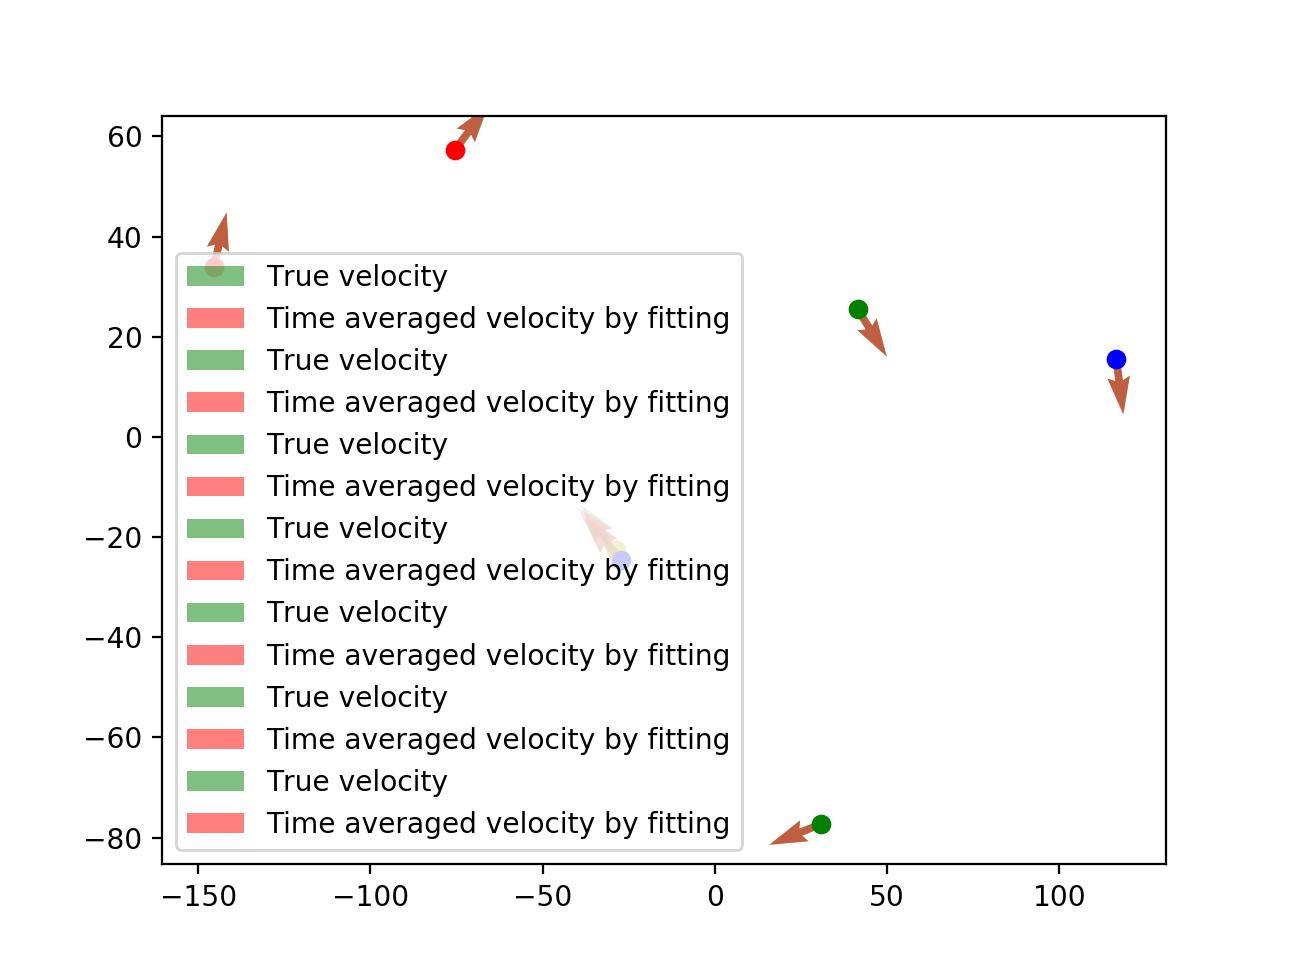

In [212]:
# Plot and compare the velocity extracted by fitting the track to the true velocity at the initial point of the track
plt.figure()

for ii in range(nTracks):
    
    plt.quiver(init_pos_x[ii], init_pos_z[ii], v_true[ii][0], v_true[ii][2], color = 'g', label = 'True velocity', alpha =0.5)
    plt.quiver(init_pos_x[ii], init_pos_z[ii], centroids_velocity_x[ii], centroids_velocity_z[ii], color = 'r', label = 'Time averaged velocity by fitting', alpha =0.5)

    plt.scatter(init_pos_x[ii], init_pos_z[ii])

plt.legend()
plt.show()

# Velocity-based fitting

In [213]:
# Build the matrix A and the data vector
matrix_A = np.zeros((2*nTracks, 3))
data_vector_fit = np.zeros(2*nTracks)
data_vector_true = np.zeros(2*nTracks)

for ii in range(nTracks):
    r_x, r_y, r_z = init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]
    
    matrix_A[2*ii,:] = [0, r_z, r_y]
    matrix_A[2*ii +1, :] = [1, -r_x, 0]
    
    data_vector_fit[2*ii] = centroids_velocity_x[ii]
    data_vector_fit[2*ii+1] = centroids_velocity_z[ii]
    
    data_vector_true[2*ii] = v_true[ii][0]
    data_vector_true[2*ii+1] = v_true[ii][2]

    
# Compute the least-squares solution using lin alg

least_sq_soln_fit_velocity = np.matmul(np.linalg.pinv(matrix_A), data_vector_fit)

least_sq_soln_true_velocity = np.matmul(np.linalg.pinv(matrix_A), data_vector_true)




In [215]:
print('Least-squares solution (Fit velocity): {}'.format(least_sq_soln_fit_velocity))
print('Least-squares solution (True velocity): {}'.format(least_sq_soln_true_velocity))
print('Actual solution: {}'.format(omega_vect_true))

omega_fit = np.sum(least_sq_soln_fit_velocity**2)**(1/2)

print('Predicted angular speed (fit): {}'.format(omega_fit))
print('True angular speed: {}'.format(omega_true))
print('Relative error {}(%)'.format(100*abs(omega_fit-omega_true)/omega_true))

print('Predicted angular velocity orientation: {}'.format(least_sq_soln_fit_velocity/omega_fit))
print('True angular velocity orientation: {}'.format([p_x_true, p_y_true, p_z_true]))


Least-squares solution (Fit velocity): [ 0.01293573  0.0199862  -0.00010857]
Least-squares solution (True velocity): [-5.55111512e-17  2.00000000e-02 -6.50521303e-19]
Actual solution: [0.   0.02 0.  ]
Predicted angular speed (fit): 0.023807416257775958
True angular speed: 0.02
Relative error 19.03708128887979(%)
Predicted angular velocity orientation: [ 0.54334885  0.83949463 -0.00456025]
True angular velocity orientation: [0.0, 1.0, 0.0]


<IPython.core.display.Javascript object>


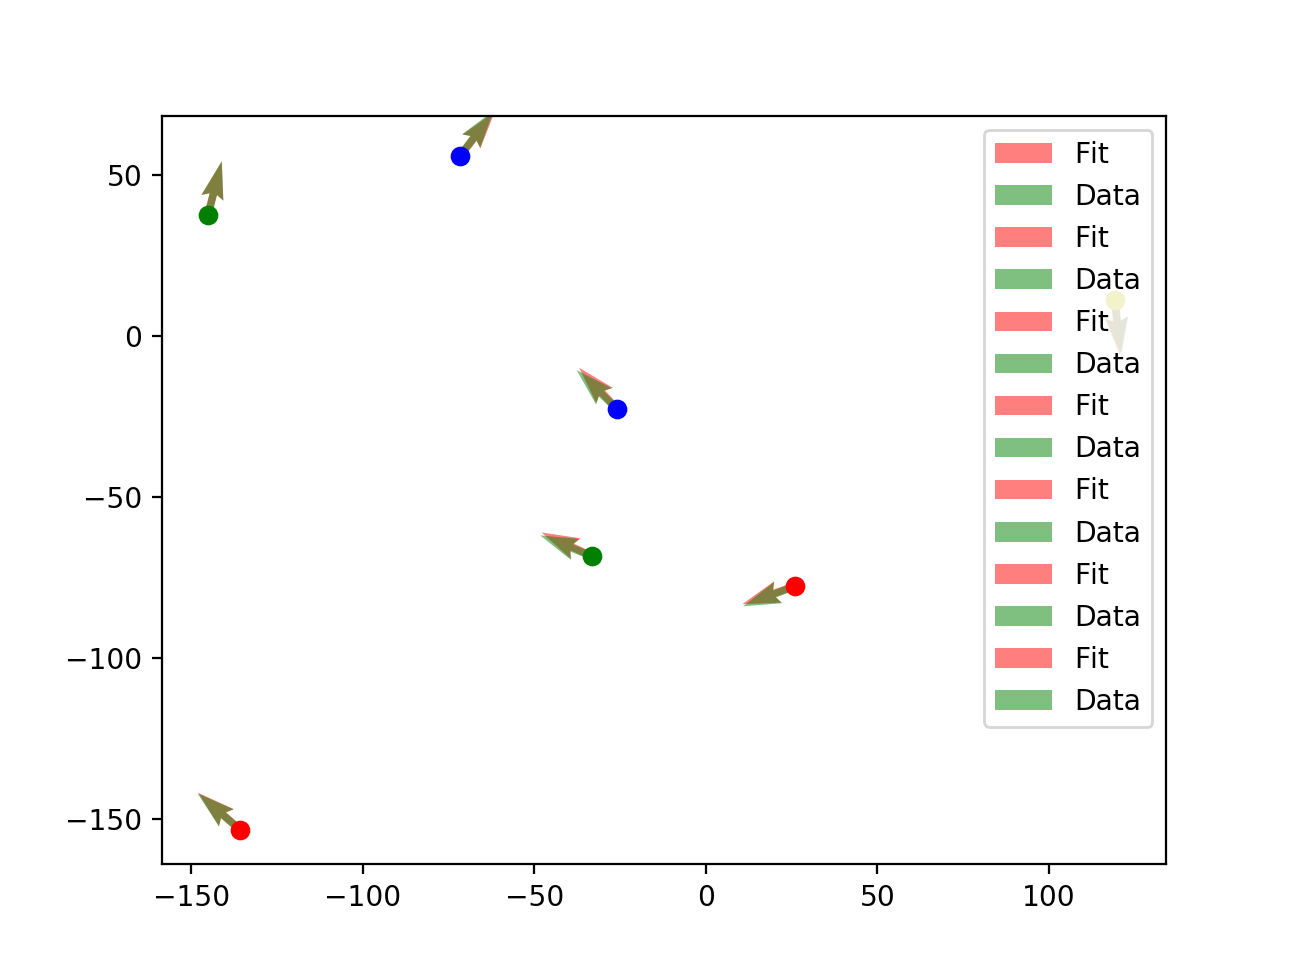

<IPython.core.display.Javascript object>


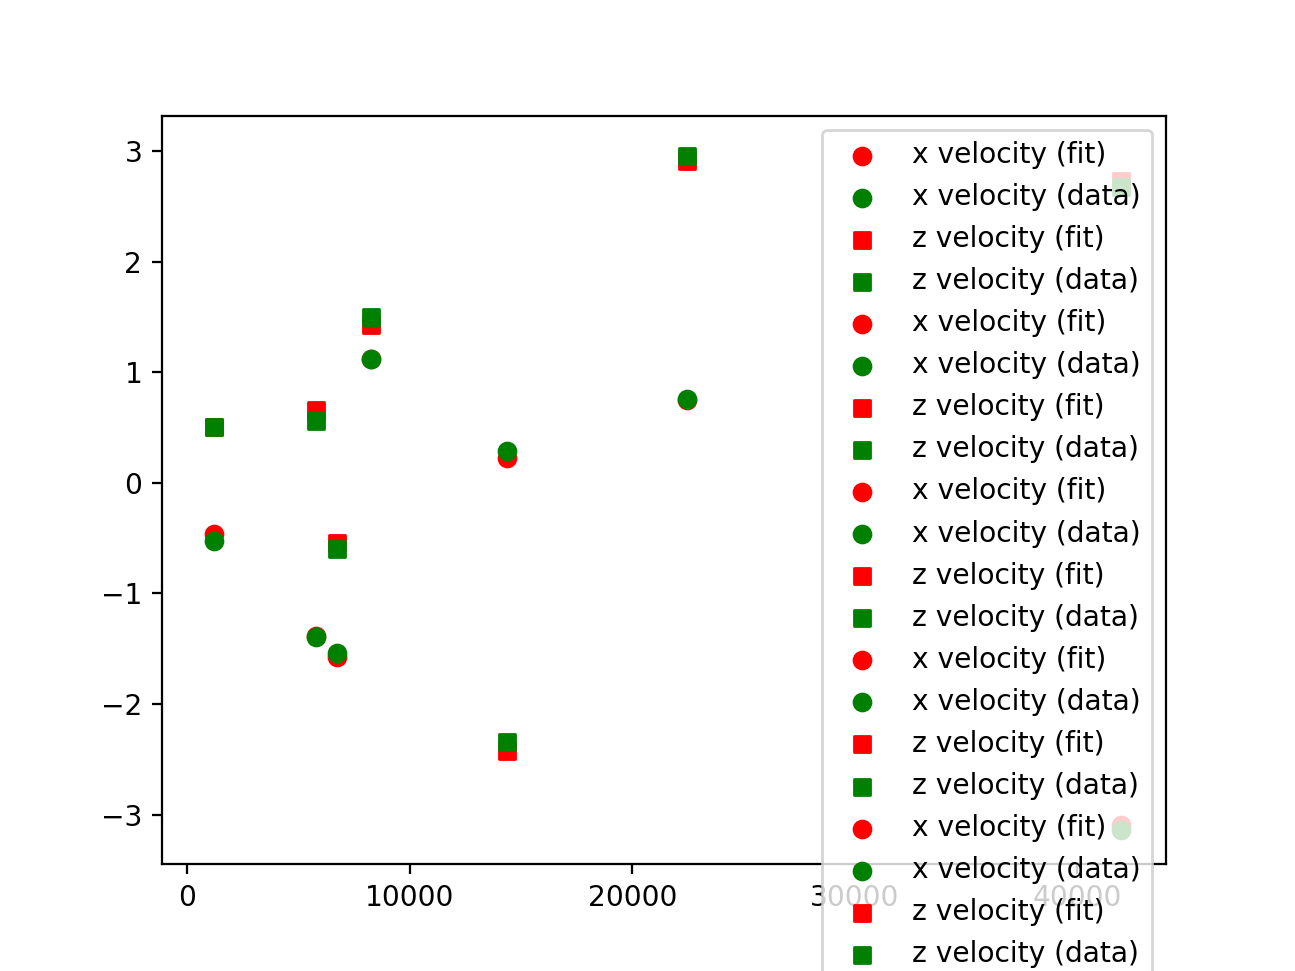

<IPython.core.display.Javascript object>


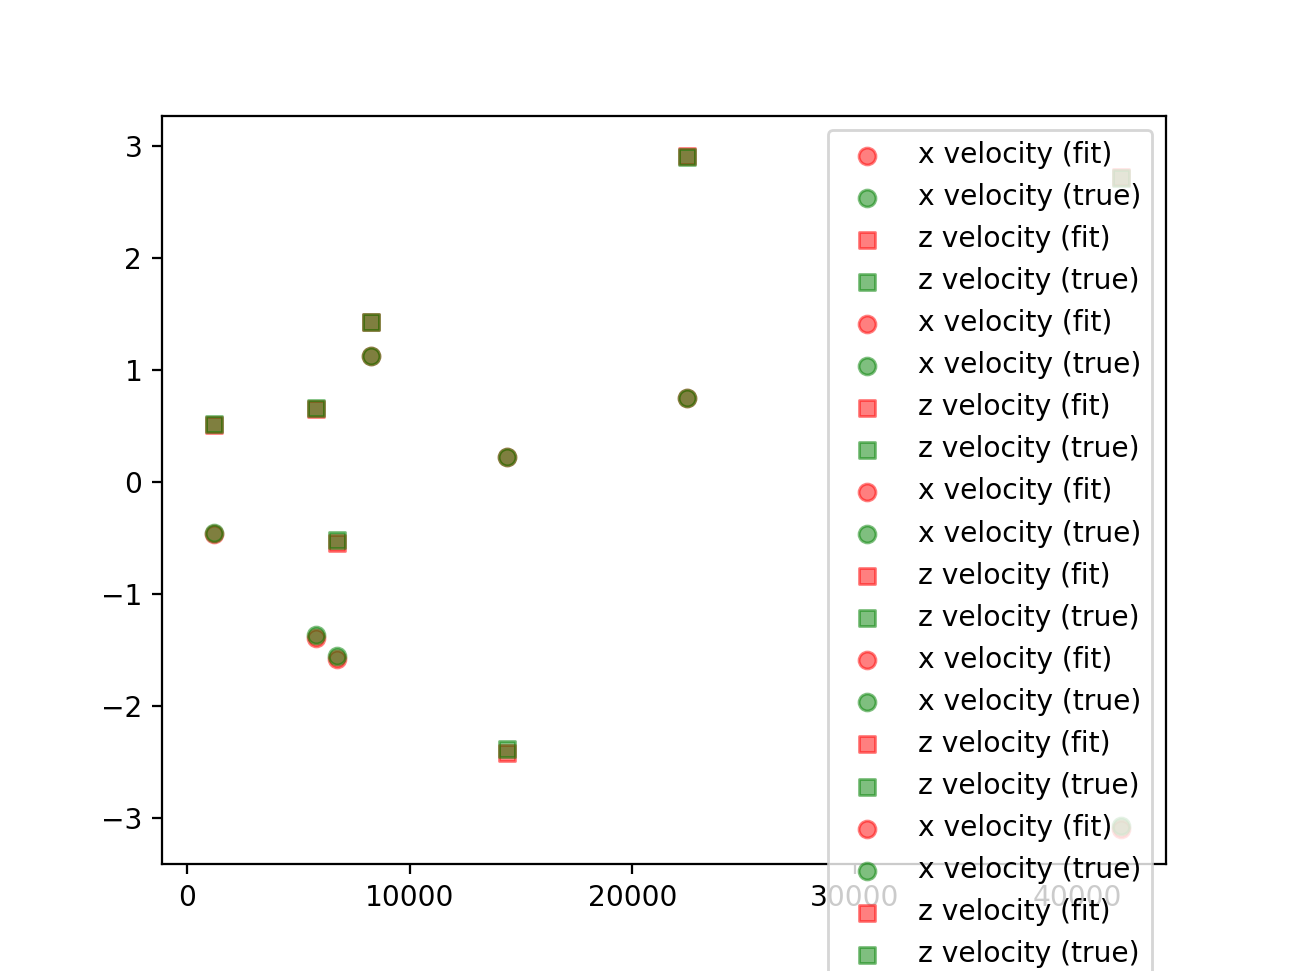

In [194]:
# Predicted translational velocities based on angular velocity fit
velocity_vect_fit = np.matmul(matrix_A, least_sq_soln_fit_velocity)


plt.figure()

for ii in range(nTracks):
    
    plt.quiver(init_pos_x[ii], init_pos_z[ii], velocity_vect_fit[2*ii], velocity_vect_fit[2*ii+1], color = 'r', label = 'Fit', alpha =0.5)
    plt.quiver(init_pos_x[ii], init_pos_z[ii], centroids_velocity_x[ii], centroids_velocity_z[ii], color = 'g', label = 'Data', alpha =0.5)

    plt.scatter(init_pos_x[ii], init_pos_z[ii])
    

plt.legend()
plt.show()

plt.figure()

for ii in range(nTracks):
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii], marker = 'o',label='x velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, centroids_velocity_x[ii], marker = 'o', label='x velocity (data)', color = 'g')
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii+1], marker = 's',label='z velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, centroids_velocity_z[ii], marker = 's', label='z velocity (data)', color = 'g')
    

plt.legend(loc='best')
plt.show()

plt.figure()

for ii in range(nTracks):
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii], alpha = 0.5, marker = 'o',label='x velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, v_true[ii][0], alpha = 0.5, marker = 'o', label='x velocity (true)', color = 'g')
    
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, velocity_vect_fit[2*ii+1], alpha = 0.5, marker = 's',label='z velocity (fit)', color = 'r')
    plt.scatter(init_pos_x[ii]**2 + init_pos_z[ii]**2, v_true[ii][2],alpha = 0.5, marker = 's', label='z velocity (true)', color = 'g')
    

plt.legend(loc='best')
plt.show()


# Trajectory-based fitting

In [107]:
# Generate the data for the fitting (trajectory of centroids relative to the sphere center)

data = []


for ii in range(nTracks):
    r_x, r_z = centroids_x[ii], centroids_z[ii]
    
    data = np.concatenate((data, r_x[1:], r_z[1:]), axis = None)  # Exclude the first point since it's used as an initial condition for the model


print(data.shape)

(480,)


{0: -146.50241088867188, 1: -116.9710693359375, 2: -75.49198913574219, 3: 113.5128173828125, 4: 39.495452880859375}
{0: 168.26475487905583, 1: 93.63717930690325, 2: 205.70408429854467, 3: 190.99326367284135, 4: 208.41360428875495}
{0: 20.000396728515625, 1: -166.51080322265625, 2: 46.50579833984375, 3: 28.50286865234375, 4: -71.97137451171875}


28299.0

In [109]:
# Checking with known parameter values
# setup the "Model" (rotation about an arbitrary axis)

from scipy.spatial.transform import Rotation as R


omega_vect = 0.02*np.array([0,1,0]) 
time_diff = np.ones(nTimepoints-1)

r = R.from_rotvec(omega_vect)

model = []

pos_array = {key: np.zeros((3, len(time_diff))) for key in init_pos_x.keys()}


for ii in init_pos_x.keys():

    r_init = np.stack((init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]))

    for jj, delta_t in enumerate(time_diff):

        if(jj == 0):
            pos_array[ii][:, jj] = r.apply(r_init) # We don't want the first point included since it's used an an initial condition for the model
        else:
            pos_array[ii][:, jj] = r.apply(pos_array[ii][:, jj-1])


    r_x_model, r_z_model = pos_array[ii][0,:], pos_array[ii][2,:]

    model = np.concatenate((model, r_x_model, r_z_model), axis = None)
    
print(model.shape)
print(data.shape)

(480,)
(480,)


<IPython.core.display.Javascript object>


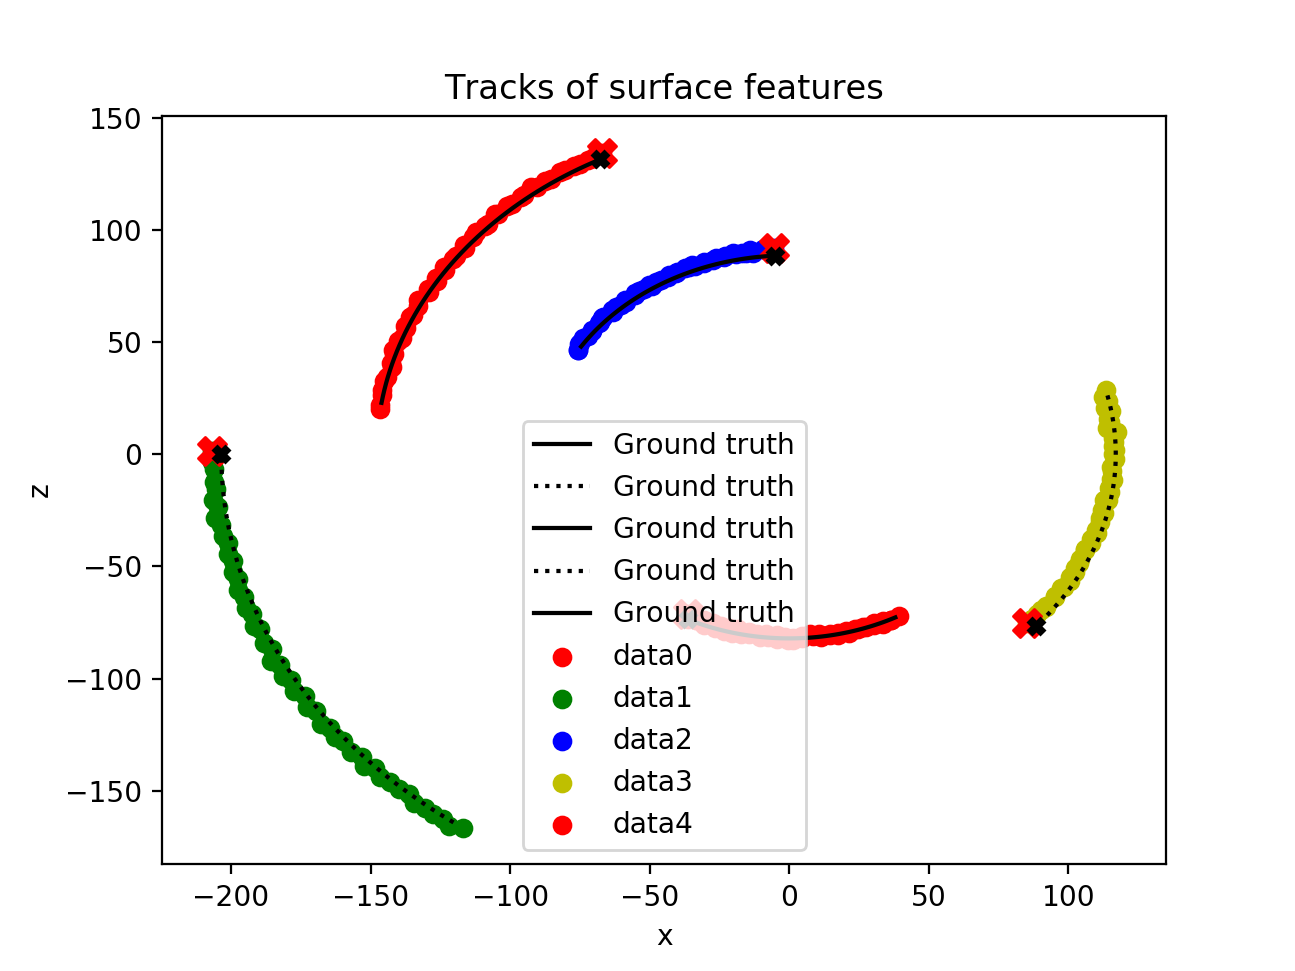

In [110]:
# Print data vs known parameter
plt.figure()

for ii in range(nTracks):
    
    plt.scatter(centroids_x[ii], centroids_z[ii], label = 'data' +str(ii))
    plt.plot(pos_array[ii][0,:], pos_array[ii][2,:], color = 'k', label = 'Ground truth')
    plt.plot(pos_array[ii][0,-1], pos_array[ii][2,-1], color = 'k', marker = 'X')
    plt.scatter(centroids_x[ii][-1], centroids_z[ii][-1], 100, marker = 'X', color = 'r')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Tracks of surface features')
plt.legend()
plt.show()

In [122]:
# Setup the problem to perform least-sq fitting of the trajectory.

from lmfit import Minimizer, Parameters, fit_report


def residual(params, init_pos_x, init_pos_y, init_pos_z, time_diff, data = None):
    
    omega_vect = np.array([0, params['omega_y'], params['omega_z']])    

    r = R.from_rotvec(omega_vect)

    model = []

    pos_array = {key: np.zeros((3, len(time_diff))) for key in init_pos_x.keys()}


    for ii in init_pos_x.keys():

        r_init = np.stack((init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]))

        for jj, delta_t in enumerate(time_diff):

            if(jj == 0):
                pos_array[ii][:, jj] = r.apply(r_init) # We don't want the first point included since it's used an an initial condition for the model
            else:
                pos_array[ii][:, jj] = r.apply(pos_array[ii][:, jj-1])


        r_x_model, r_z_model = pos_array[ii][0,:], pos_array[ii][2,:]

        model = np.concatenate((model, r_x_model, r_z_model), axis = None)
            
        
    
    return model - data

time_diff = np.ones(nTimepoints-1)

# orient_vect = [0,1,0]

fit_params = Parameters()
fit_params.add(name = 'omega_y', value= 0.2, min=0.0, max=0.5)
fit_params.add(name = 'omega_z', value= 0.0, min=0.0, max=0.5)


# Setup the least-squares problem
fit = Minimizer(residual, fit_params, fcn_args=(init_pos_x, init_pos_y, init_pos_z, time_diff,), fcn_kws={'data': data},scale_covar=True)
fit.minimize(method = 'leastsq')

result = fit.leastsq()
init = residual(fit_params, init_pos_x, init_pos_y, init_pos_z, time_diff, data = data)
fit = residual(result.params, init_pos_x, init_pos_y, init_pos_z, time_diff, data = data)

result.params
# out = minimize(residual, fit_params, args=(init_pos_x, init_pos_y, init_pos_z, time_diff,), kws={'data': data}, method = 'cg')
# print(fit_report(out))

name,value,standard error,relative error,initial value,min,max,vary
omega_y,0.20000000,0.00228206,(1.14%),0.2,0.00000000,0.50000000,True
omega_z,0.00000000,3.7117e-11,(inf%),0.0,0.00000000,0.50000000,True


name,value,standard error,relative error,initial value,min,max,vary
omega_y,0.02008733,1.9644e-05,(0.10%),0.05,0.00000000,0.20000000,True
omega_z,2.7898e-04,1.5292e-05,(5.48%),0.05,0.00000000,0.20000000,True


In [115]:
# Plot the residual as a function of the parameters
def residual_func(p_y, p_z, init_pos_x, init_pos_y, init_pos_z, time_diff, data = None):
    
    omega_vect = np.array([0, p_y, p_z])    

    r = R.from_rotvec(omega_vect)

    model = []

    pos_array = {key: np.zeros((3, len(time_diff))) for key in init_pos_x.keys()}


    for ii in init_pos_x.keys():

        r_init = np.stack((init_pos_x[ii], init_pos_y[ii], init_pos_z[ii]))

        for jj, delta_t in enumerate(time_diff):

            if(jj == 0):
                pos_array[ii][:, jj] = r.apply(r_init) # We don't want the first point included since it's used an an initial condition for the model
            else:
                pos_array[ii][:, jj] = r.apply(pos_array[ii][:, jj-1])


        r_x_model, r_z_model = pos_array[ii][0,:], pos_array[ii][2,:]

        model = np.concatenate((model, r_x_model, r_z_model), axis = None)
            
        
    
    return np.sum((model - data)**2)
    

# Make a 2D array for the parameter-space

p_y_array = np.arange(0, 0.5, 0.01)
p_z_array = np.arange(0, 0.5, 0.01)
p_y_matrix, p_z_matrix = np.meshgrid(p_y_array, p_z_array)

residual_array = np.zeros_like(p_y_matrix)

print(residual_array.shape)
for ii in range(len(p_y_array)):
    
    for jj in range(len(p_z_array)):
        
        residual_array[ii,jj] = residual_func(p_y_matrix[ii,jj], p_z_matrix[ii,jj], init_pos_x, init_pos_y, init_pos_z, time_diff, data = data)
        

        
        

(50, 50)


<IPython.core.display.Javascript object>


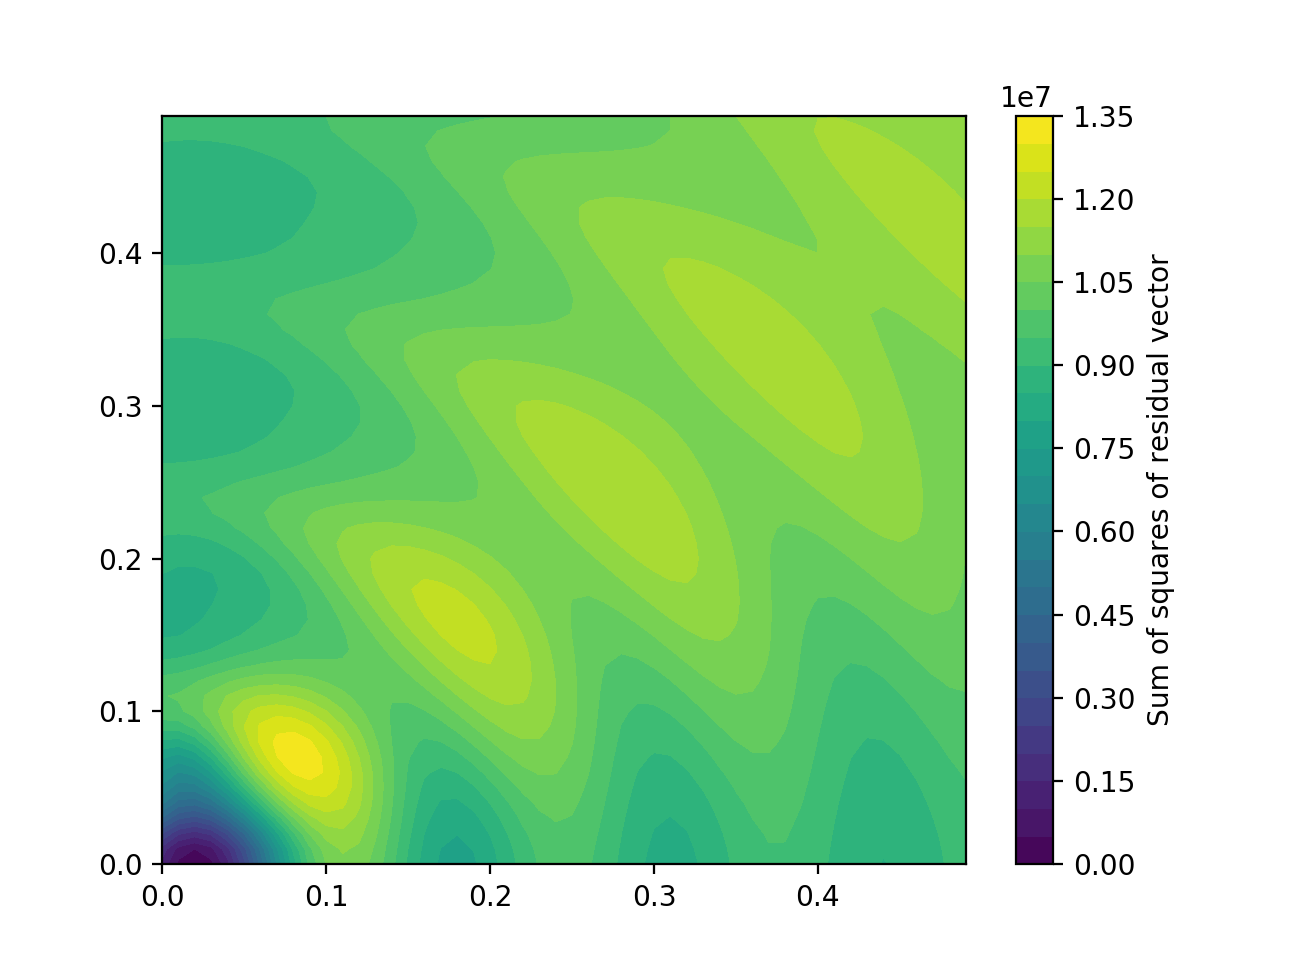

In [116]:
# Plot the residual as a function of the parameter space

plt.figure()
CS = plt.contourf(p_y_array,p_z_array,residual_array, levels = 30)
fig = plt.gcf()
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Sum of squares of residual vector')
plt.savefig('Residual contours vs fitting params_5tracks.png', dpi = 300)
plt.show()

name,value,initial value,min,max,vary
r_init,-inf,None,-inf,inf,False
omega,1.00000000,None,-inf,inf,True
p_x,1.00000000,None,-inf,inf,True
p_y,1.00000000,None,-inf,inf,True
p_z,1.00000000,None,-inf,inf,True


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])